In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam
import keras
# Conv1D + LSTM
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import Flatten

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_dk=pd.read_csv('/content/drive/MyDrive/RESEARCH_VANSHIKA/IoT_Conference_Paper/Data2.csv')
df_dk.head(5)

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
0,0.0,5.728385,54,54562,1883,0.0,0,445,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
1,0.0,5.752061,54,54562,1883,0.0,0,485,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
2,0.0,5.752335,54,54562,1883,0.0,0,505,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
3,0.0,5.752947,54,54562,1883,0.0,0,525,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1
4,0.0,6.096030,54,54562,1883,0.0,0,1181,0,0,...,0,0,0.0,0,0,0,6,64,Attack,1


In [4]:
col_list = ["frame.time_delta",	"frame.time_relative",	"frame.len"	,	
            "tcp.time_delta",	"tcp.len",	"tcp.ack",	"tcp.connection.fin",	"tcp.connection.rst",	"tcp.connection.sack",	
            "tcp.connection.syn",	"tcp.flags.ack",	"tcp.flags.fin",	"tcp.flags.push",	"tcp.flags.reset",	"tcp.flags.syn",
            "tcp.flags.urg",	"tcp.hdr_len",	"tcp.pdu.size",	"tcp.window_size_value",		
            "mqtt.clientid_len",	"mqtt.conack.val",	"mqtt.conflag.passwd",	"mqtt.conflag.qos",	"mqtt.conflag.reserved",	
            "mqtt.conflag.retain",	"mqtt.conflag.willflag", 
            "mqtt.dupflag",		"mqtt.kalive",	"mqtt.len",	"mqtt.msg",	"mqtt.msgtype",	"mqtt.qos",	"mqtt.retain",
            "mqtt.topic",
            "mqtt.topic_len",	"mqtt.ver",	"mqtt.willmsg_len",	"ip.proto",	"ip.ttl",	"class",	"label"

           ]

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
cat_features = ['class']
encoder = LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = label_encoder.fit_transform(df_dk[cat_features])
    df_dk['class'] = encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
len(df_dk)

188694

In [7]:
df_dk.dtypes

frame.time_delta         float64
frame.time_relative      float64
frame.len                  int64
tcp.srcport                int64
tcp.dstport                int64
tcp.time_delta           float64
tcp.len                    int64
tcp.ack                    int64
tcp.connection.fin         int64
tcp.connection.rst         int64
tcp.connection.sack        int64
tcp.connection.syn         int64
tcp.flags.ack              int64
tcp.flags.fin              int64
tcp.flags.push             int64
tcp.flags.reset            int64
tcp.flags.syn              int64
tcp.flags.urg              int64
tcp.hdr_len                int64
tcp.pdu.size               int64
tcp.window_size_value      int64
mqtt.clientid_len          int64
mqtt.conack.val            int64
mqtt.conflag.passwd        int64
mqtt.conflag.qos           int64
mqtt.conflag.reserved      int64
mqtt.conflag.retain        int64
mqtt.conflag.willflag      int64
mqtt.dupflag               int64
mqtt.kalive                int64
mqtt.len  

In [8]:
print(df_dk.isna().sum().sum())
df_dk=df_dk.dropna()
print(df_dk.isna().sum().sum())

142272
0


In [9]:
df_dk.sample(5)

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
14402,0.000018,6.301043,54,54571,1883,0.000028,0,7853,0,0,...,0,0,0.0,0,0,0,6,64,0,1
177009,0.000072,12.622737,60,1883,54542,0.000072,4,595220,0,0,...,0,0,0.0,0,0,0,6,128,0,1
21357,0.000617,124.490041,78,50716,1883,0.000000,0,0,0,0,...,0,0,0.0,0,0,0,6,64,0,1
156767,0.000029,0.590028,74,1883,59036,0.000029,0,1,0,0,...,0,0,0.0,0,0,0,6,64,0,1
160549,0.000002,44.028037,438,1883,54558,0.004609,384,619272,0,0,...,0,0,0.0,0,0,0,6,128,0,1


In [10]:
df_dk.groupby('label').size()

label
0    19232
1    53561
dtype: int64

In [11]:
for col in (df_dk.iloc[:,:-1].columns):
    if(df_dk[col].min()==df_dk[col].max()):
            df_dk.drop(col, axis=1, inplace=True)

In [12]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_dk.iloc[:,:-1].columns):
    standardize (df_dk,i)

df_dk.head()

,frame.time_delta,frame.time_relative,frame.len,tcp.srcport,tcp.dstport,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,tcp.pdu.size,tcp.window_size_value,mqtt.clientid_len,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.ver,ip.ttl,class,label
0,-0.032272,-0.446647,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491864,-0.112701,-0.151486,...,-0.173083,0.009637,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
1,-0.032272,-0.446626,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491746,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
2,-0.032272,-0.446626,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491687,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
3,-0.032272,-0.446625,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.491629,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1
4,-0.032272,-0.446326,-0.488833,1.241355,-1.121817,-0.185499,-0.262305,-0.489702,-0.112701,-0.151486,...,-0.173083,0.010000,-0.042115,-0.119078,-0.10662,-0.815009,-0.16691,-0.696107,-0.556621,1


In [13]:
target=['label']
features = [c for c in df_dk.columns if c!="label"]

In [14]:
X = df_dk[features].values # Features
y = df_dk[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((72793, 27), (72793, 1))

In [15]:
del df_dk

In [16]:
gc.collect()

0

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [18]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((58234, 27), (14559, 27), (58234, 1), (14559, 1))

In [19]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(58234, 27, 1)
(14559, 27, 1)


In [20]:
learning_rate=0.001
batch_size=5000
epochs = 10

model_save = ModelCheckpoint('./modelIoTHC.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 8, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.6, 
                              patience = 4, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

In [21]:
X_test.shape[1]

27

In [22]:
model = Sequential()
model.add(Conv1D(16,2,input_shape = (X_test.shape[1], 1)))
model.add(Conv1D(16,2))
model.add(MaxPooling1D(1))


model.add(Conv1D(32,2))
model.add(Conv1D(32,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(64,2))
model.add(Conv1D(64,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(128,2))
model.add(Conv1D(128,2))
model.add(MaxPooling1D(1))

#model.add(LSTM(32, activation = 'relu', return_sequences=True))
#model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=learning_rate)
#model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[keras.metrics.AUC(name='auc')])


history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.2055 - auc: 0.9825
Epoch 1: val_loss improved from inf to 0.01697, saving model to ./modelIoTHC.h5
11/11 [==============================] - 26s 2s/step - loss: 0.2055 - auc: 0.9825 - val_loss: 0.0170 - val_auc: 1.0000 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.0103 - auc: 0.9999
Epoch 2: val_loss improved from 0.01697 to 0.00010, saving model to ./modelIoTHC.h5
11/11 [==============================] - 19s 2s/step - loss: 0.0103 - auc: 0.9999 - val_loss: 9.6703e-05 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 0.0020 - auc: 1.0000
Epoch 3: val_loss improved from 0.00010 to 0.00005, saving model to ./modelIoTHC.h5
11/11 [==============================] - 22s 2s/step - loss: 0.0020 - auc: 1.0000 - val_loss: 5.4252e-05 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.0016 - auc:

In [23]:
y_pred = model.predict(X_test_cnn, batch_size=512)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

29/29 [==============================] - 1s 37ms/step
AUC: 1.000


In [24]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('finalmodel.csv')

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

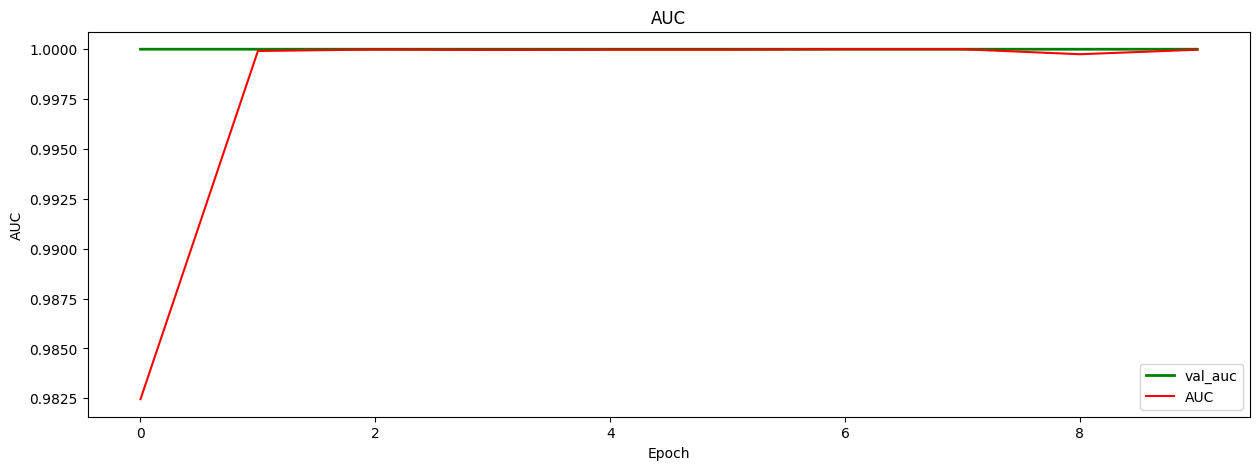

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_auc'],label='val_auc',color = "green" ,
     linewidth=2, markersize=12)
plt.plot(range(history.epoch[-1]+1),history.history['auc'],label='AUC', color = "red" )
plt.title('AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC');plt.legend(); 
plt.show()

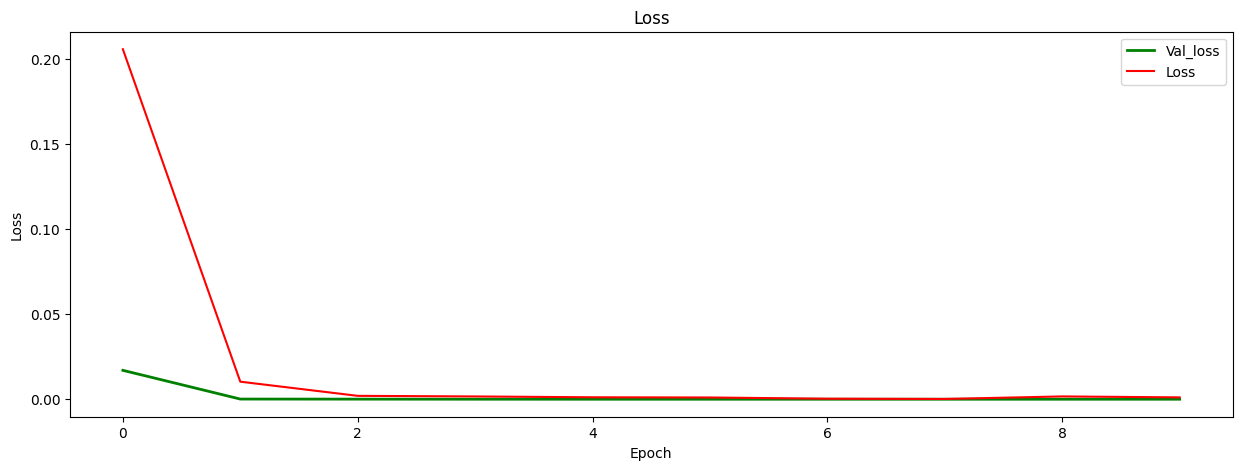

In [27]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss',color = "green" ,
     linewidth=2, markersize=12)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Loss', color = "red")
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss');plt.legend(); 
plt.show()

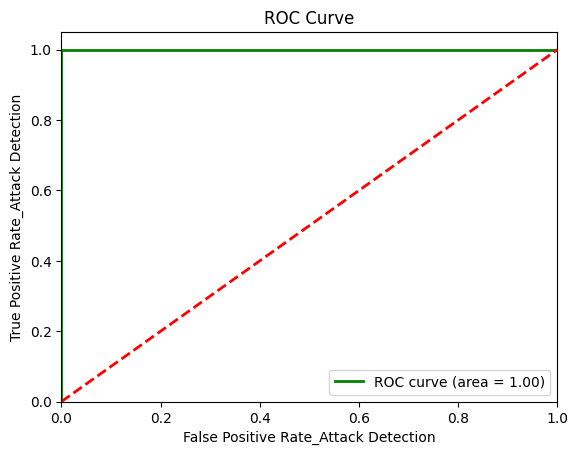

In [28]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate_Attack Detection')
    plt.ylabel('True Positive Rate_Attack Detection')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
generate_results(y_test, y_pred)

In [ ]:
#def get_classification_metric(testy, probs):
 ##  precision, recall, thresholds = precision_recall_curve(testy, probs[:,1])
    # convert to f score
   # fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    #ix = np.argmax(fscore)
    #return fscore[ix]

In [ ]:
#metric = get_classification_metric
#print(metric)

<function get_classification_metric at 0x7f81762a0940>


In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

sns.set(style="whitegrid")

In [40]:
nsamples, nx, ny = X_train_cnn.shape
d2_train_dataset = X_train_cnn.reshape((nsamples,nx*ny))